<a href="https://colab.research.google.com/github/hadiwyne/msft-stock-prediction/blob/main/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction

## Introduction
To make money from stock trading, we would want to invest on days when the value of our stock will go up. In order to get this investment edge, we will use a machine learning algorithm to predict whether the price will rise tomorrow. Our approach is simple:
- **If the model predicts an increase**, we buy.
- **Otherwise, we do nothing.**

## Goal
Our priority is maximizing **true positives** i.e. correctly predicting price increases. To achieve this, we’ll use **precision** as our error metric:



Precision = True Positives / (False Positives + True Positives)



## Trade-offs
- **Minimizing false positives**: We avoid buying when prices drops which would reduce unnecessary losses.
- **Accepting false negatives**: And though we may miss profitable opportunities, our main goal is loss minimization rather than maximizing gains, which is why it's fine.

# Downloading the Data

We'll use Python's yfinance package to import Yahoo Finance's data on stock prices. Our focus will be Microsoft's stock, since it has very interesting historical trends. We believe that the patterns typical of Microsoft's history are very good for this project

In [7]:
import yfinance as yf
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period = "max")

Let's explore Microsoft's stock history by taking a quick look through the dataset

In [8]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054277,0.062259,0.054277,0.059598,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.059598,0.062791,0.059598,0.061726,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.061726,0.063323,0.061726,0.062791,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.062791,0.063323,0.060662,0.061194,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061194,0.061726,0.059598,0.060130,47894400,0.0,0.0


What we have here is a **time-series dataset** from each trading day, and since Microsoft's stock first started trading in 1986, our first row contains data from that date. We can also see that the stock opened at 5 cents on its first day, and its highest price was 6 cents. And so, each of the column tells something about the stock a particular date.

- Volume tells the number of shares bought and sold on a particular day
- Dividends are a portion of a company's profits distributed to its shareholders
- A stock split increases the number of outstanding shares by dividing existing shares into multiple new shares

Let's plot the closing prices of the dataset by day, by using the plot method

<Axes: xlabel='Date'>

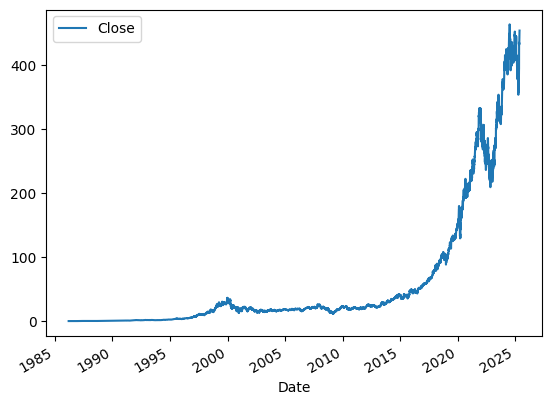

In [9]:
msft_hist.plot.line(y = "Close", use_index = True)

As we can see here, the closing price back in 1986 was considerably low, but today it stands abvoe 400USD.

# Preparing the Data for Machine Learning

Because we have time-series data, we have to be extra careful as to prevent **data leakage.** Data leakage, or leakage, happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

Let's set up the data with our target, which is the value we want to predict i.e. if the price is going to go up or down tomorrow. We will use the pandas' rolling method. What it does is it moves across every 2 rows in the dataset.

Our implementation: if the second row is higher than the first row, return 1. Else return 0. What we want to see is that if the closing price on any given day is higher than the closing price on the previous day

In [10]:
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close': 'Actual_Close'})
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

Now, let's look at our newly created data dataset to see what we've created

In [11]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.059598,NaN
1986-03-14 00:00:00-05:00,0.061726,1.0
1986-03-17 00:00:00-05:00,0.062791,1.0
1986-03-18 00:00:00-05:00,0.061194,0.0
1986-03-19 00:00:00-05:00,0.060130,0.0


This newly created dataset contains our actual closing price of the day under the **Actual_Close** column, and our **Target** column, which tells whether the price has increased or not. The first row has NaN in Target because there's no row before it. This **Target** column will be the target that our Machine Learning algorithm will use to train on, and make future predictions with.

# Checking for Class Imbalance

In [12]:
data["Target"].value_counts()

,count
Target,
1.0,5005
0.0,4866


As we can see here, the classes are pretty close to each other, meaning there's no imbalance for us to consider and fix.

# Setting up the Predictor

Now that we have our Target, we need the variables that we will use to make the predictions. In order to achieve that, we will first shift our data forwards.

In [13]:
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

Now, let's take a look at what we've just created

In [14]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.059598,0.062791,0.059598,0.061726,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.061726,0.063323,0.061726,0.062791,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.062791,0.063323,0.060662,0.061194,6.776640e+07,0.0,0.0


As we can see, we've shifted our prices a day ahead. So, the closing price on 1986-03-13, which was 0.059598, is now on 1986-03-14. And the first column is now completely NaN.

The reason we've shifted the dataset is because in the real-world stock trading, when predicting tomorrow’s price, we don’t actually know tomorrow’s actual closing price. If we mistakenly feed it into the model, it creates an unfair advantage during training, which makes the model seem highly accurate on historical data but unreliable in real scenarios.

By shifting historical data forward, using yesterday’s prices to predict today’s, we can mimic the real-world, and confirm that the model is tested under realistic conditions.

Now, let's combine this new dataset with the columns that we want to use to make our predictions.

In [15]:
predictors = ["Close", "High", "Low", "Open", "Volume"]
data = data.join(msft_prev[predictors]).iloc[1:]

Our **Predictors** are the columns that we want to use to make our predictions. We've also skip the first row, since it contains only NaN values after we made the shift. Now, let's look at our newly created dataset.

In [16]:
data.head()

,Actual_Close,Target,Close,High,Low,Open,Volume
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.061726,1.0,0.059598,0.062259,0.054277,0.054277,1.031789e+09
1986-03-17 00:00:00-05:00,0.062791,1.0,0.061726,0.062791,0.059598,0.059598,3.081600e+08
1986-03-18 00:00:00-05:00,0.061194,0.0,0.062791,0.063323,0.061726,0.061726,1.331712e+08
1986-03-19 00:00:00-05:00,0.060130,0.0,0.061194,0.063323,0.060662,0.062791,6.776640e+07
1986-03-20 00:00:00-05:00,0.058533,0.0,0.060130,0.061726,0.059598,0.061194,4.789440e+07


Now we can see that our dataset starts from the 14th instead of the 13th in the original dataset. We no longer have the NaN row in this dataset. We also have our **Actual_Close** and **Target** columns, but we can see that our **Actual_Close** is from a day ahead. The **Close** column still has the real closing price, but the **Actual_Close** column contains the closing price of the day ahead.

This will help our model use the prices from 1986-03-13 to predict what happened on 1986-03-14. So our model will no longer use the data that we already have to predict what happened in the past. Rather, it will use the past's data to predict the future. This will help us prevent leakage.

# Training the initial Machine Learning Model

For this project, I will use Random Forest Classifier from sci-kit learn. Because our Target is in binary i.e. 0 and 1, we will use classification instead of the typical Regression model. Let's import our model.

In [17]:
from sklearn.ensemble import RandomForestClassifier

Let's initialize the model.

- In our parameters, we've set `n_estimaters = 100` because we want to train a 100 decision trees. A Random Forest Classifier is composed of individual decision trees, and this parameter decides how many decision trees we want.
- We've set the `min_samples_split = 200` because  the decision trees in a Random Forest Classifier can easily overfit the data. This will prevent the decision trees from overfitting with the data.
- An arbitrary `random_state = 1` was decided to allow replicability of this model's findings.



In [18]:
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 200, random_state = 1)

For this initial model, we will train the model on all the rows except the last 100 rows, and predict the last 100 rows using the model.

In [19]:
train = data.iloc[:-100]
test = data.iloc[-100:]

Now, let's fit our model on the training dataset, with our predictors and target. What this fit method does is it tells the model to use the predictors to predict the target.

In [20]:
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

# Model Scoring

Now that we've fit our model, let's make some predictions and see how accurate our model is.

In order to achieve this, we will import Precision Score from sci-kit-learn. The Precision Score is used to see how many True Positives our model predicted. This is because we are not trying to maximize our gains, but minimize our losses. So we're only concerned with whether the algorithm accurately predicts whether the price of the stock will go up. It is not our concern to see whether if the model says the price will go down, but it actually goes up, preventing us from making that valuable investment. We want to make risk-free investments. We've given the formula for this above. However, a simpler explanation of of this score is:

Days when the model predicted that the prices will go up and the prices actually went up (True Positives) divided by All of the times the model predicted that the prices will go up (False Positives + True Positives)

In [21]:
from sklearn.metrics import precision_score

First, let's generate some predictions on the test set, which is the last 100 rows we've kept separate from the training.

In [22]:
preds = model.predict(test[predictors])

Now, we will turn these predictions into a pandas series to make it easy to compare our predictions with the real values. This will help us score our model too. For the index of this series, we will keep it the same as the test data.

In [23]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

Let's take a look at what we've just created:

In [24]:
preds

,0
Date,
2024-12-20 00:00:00-05:00,0.0
2024-12-23 00:00:00-05:00,1.0
2024-12-24 00:00:00-05:00,1.0
2024-12-26 00:00:00-05:00,1.0
2024-12-27 00:00:00-05:00,1.0
...,...
2025-05-12 00:00:00-04:00,1.0
2025-05-13 00:00:00-04:00,1.0
2025-05-14 00:00:00-04:00,1.0


Let's calculate our precision score now.

In [25]:
precision_score(test["Target"], preds)

0.48314606741573035

Our Precision Score is 48%. Let's visualize this.

Our visualization will show what our algorithm predicted versus the actual closing prices. In order to achieve this, let's first concatenate our testing Targets with our Predictions, to allow us to compare the two easily.

In [26]:
combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis = 1)
combined

,Target,Predictions
Date,,
2024-12-20 00:00:00-05:00,0.0,0.0
2024-12-23 00:00:00-05:00,0.0,1.0
2024-12-24 00:00:00-05:00,1.0,1.0
2024-12-26 00:00:00-05:00,0.0,1.0
2024-12-27 00:00:00-05:00,0.0,1.0
...,...,...
2025-05-12 00:00:00-04:00,1.0,1.0
2025-05-13 00:00:00-04:00,0.0,1.0
2025-05-14 00:00:00-04:00,1.0,1.0


This Data frame allow us to clearly see what the model predicted versus what actually happened. Let's make a simple plot using just pandas.

<Axes: xlabel='Date'>

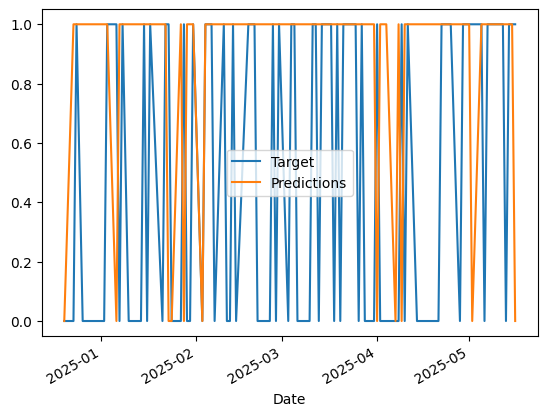

In [27]:
combined.plot()

As we can see, our model is not performing very well. For most of the rows, it's making the same predictions.



# Backtesting

To help our model, we will develop a backtesting engine. A backtesting engine will provide us predictions across the entire dataset, instead of only the last 100 rows, because only the last 100 rows do not represent the full spectrum of the possibilities in the actual world of stock market. Therefore, we want to test across the entire history of Microsoft's stock price in order to get a better error metric.

Backtesting involves the following steps:

- looping over the data
- splitting the data up
- training a new model every few rows and using it to predict the next few rows until we've performed this operation on the whole dataset

Here, we are:
- starting at the 1000th row
- training a model data from row 0 - 1000
- make predictions from row 1000 to row 100

But this method respects the sequential nature of the data, meaning that we're only using the past data to make predictions for the future data, and not the other way around.

We've set a threshold of **0.6**. Any probability greater than 0.6 is considered 1, and any probability below 0.6 is considered 0, because we want to maximize our true positives and minimize our false positives. This will allow us to only consider a more confident probability as worthy for our model to consider as 1.

Furthermore, instead of using only `.predict()` method, we've used `.predict_proba()` method here. This method returns probabilities of each row belonging to each class.  

When we begin our loop, our result comes out as a two-columned array.
- The first column is the probability of it being 0 i.e. the price will go down.
- The second column is the probability of it being 1 i.e. the price will go up.

Since we only need the second column, we'll get rid of the first column by including the `[:, 1]` part after making our predictions. We then turn our predictions into pandas series and combine our data frames again.

Except for the first 1000 rows, we now have predictions for every single row. This backtesting will allow us to test our error metric on every single row in the dataset.

In [28]:
start = 1000
step = 100

predictions = []
for i in range(start, data.shape[0], step):

      train = data.iloc[0:i].copy()
      test = data.iloc[i:(i+step)].copy()
      model.fit(train[predictors], train["Target"])
      preds = model.predict_proba(test[predictors])[:, 1]
      preds = pd.Series(preds, index=test.index)
      preds[preds > .6] = 1
      preds[preds <= .6] = 0
      combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis = 1)
      predictions.append(combined)

predictions = pd.concat(predictions)

Now, let's turn it into a function so that we can call it again whenever needed

In [29]:
def backtest(data, model, predictors, start=1000, step=100):
    predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        model.fit(train[predictors], train["Target"])
        preds = model.predict_proba(test[predictors])[:, 1]
        preds = pd.Series(preds, index=test.index)

        preds[preds > 0.6] = 1
        preds[preds <= 0.6] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        predictions.append(combined)

    predictions = pd.concat(predictions)
    return predictions

Before we proceed, let's first look at the value counts to get an idea of our dataset now.

In [30]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,8253
1.0,618


We can see here that on 511 days, we predicted that the price will go up, and on rest of the days, we predicted that the price will go down. We checked in the original value counts that the distribution of 1s and 0s was half and half, but here we see a lot fewer 1s. But our hope is that the 1s that we are predicting here are genuine 1s i.e. the price is actually going up, even if we predict very few days it will go up.

Now, let's look at our precision score and see if it has improved.

In [31]:
from sklearn.metrics import precision_score
precision_score(predictions["Target"], predictions["Predictions"])

0.5210355987055016

We've definitely improved our precision score, but still, whenever the model predicts a 1, there is a 52% chance that the model predicted correctly.

# Improving our model's accuracy

We can improve our model's accuracy by including more predictors, allowing our mdoel better predictors to make predictions with.

We will provide the algorithms the following ratios:
- between the weekly average price and the closed price
- between the quarterly average price and the closed price
- between the annual price and the closed price.

In [32]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

- `weekly_mean` looks at the weekly rolling mean for all the columns. If the rolling weekly price is lower or higher than the closing price, this is significant for the algorithm
- `weekly_trend` counts how many days in the last 7 days did the price go up or down in the **Target** column

Now, let's create more ratios between different columns in the dataset, and let's assign all these ratios to different columns, and use these columns as predictors.

In [36]:
data["weekly_mean"] = weekly_mean ["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean ["Close"] / data["Close"]
data["annual_mean"] = annual_mean ["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data ["weekly_trend"] = weekly_trend

data ["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"]= data["High"] / data["Close"]
data["low close_ratio"]= data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean","annual quarterly_mean", "weekly_trend", "open_close_ratio", "high_close_ratio", "low close_ratio"]

Now, let's make predictions using these new predictors.

In [37]:
predictions = backtest(data.iloc[365:], model, full_predictors)

And while we're at it, let's take an updated precision score.

In [38]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5985221674876847

Now that the algorithm has received more useful information, the precision score has visibly been improved. Where, previously, it was 52%, now it's 58%. This means that these updated ratios have helped our model make better predicitons. This is also known as **feature engineering**.

Let's look at value counts again to see what has improved.

In [39]:
predictions["Predictions"].value_counts()

,count
Predictions,
0.0,8100
1.0,406


We've actually further reduced the number of days that are considered safe for investment. But now we have a much higher chance of correct predictions.